In [1]:
import sys
import os
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase
from few.utils.baseclasses import Pn5AAK, ParallelModuleBase
from scipy import optimize
from scipy import interpolate
import bilby
import scipy

plt.rc('text', usetex=True)
plt.rc('font', family='calibri')

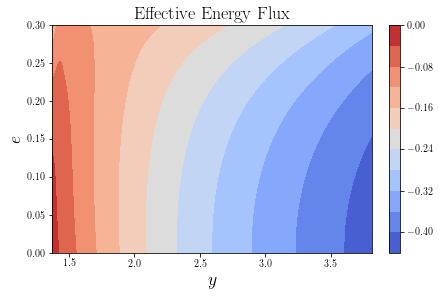

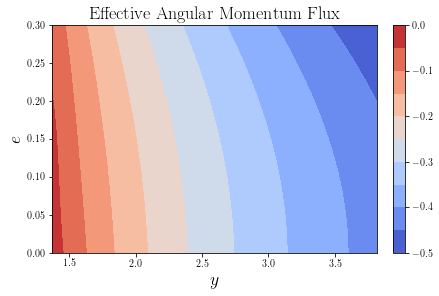

In [15]:
data=np.loadtxt('FluxScalarpefinal.txt')
scalardata=np.array(data)
xlist=np.sort(np.unique(scalardata[:,0]))
ylist=np.sort(np.unique(scalardata[:,1]))
energyvalues=scalardata[:,2]
angularvalues=scalardata[:,3]
x, y = np.meshgrid(xlist, ylist)

origin = 'lower'
# levels=np.array([-0.5,-0.4,-0.3,-0.2,-0.1,0.0])
fig1, ax2 = plt.subplots(constrained_layout=True)
CS = ax2.contourf(x, y, energyvalues.reshape(-1,len(ylist)),10, cmap=plt.cm.coolwarm, origin=origin)
ax2.set_title(r'Effective Energy Flux',fontsize=18)
ax2.set_xlabel(r'$y$',fontsize=18)
ax2.set_ylabel(r'$e$',fontsize=18)
cbar = fig1.colorbar(CS)
plt.savefig('effectiveenergyflux.pdf')

origin = 'lower'
fig1, ax2 = plt.subplots(constrained_layout=True)
CS = ax2.contourf(x, y, angularvalues.reshape(-1,len(ylist)), 10, cmap=plt.cm.coolwarm, origin=origin)
ax2.set_title(r'Effective Angular Momentum Flux',fontsize=18)
ax2.set_xlabel(r'$y$',fontsize=18)
ax2.set_ylabel(r'$e$',fontsize=18)
cbar = fig1.colorbar(CS)
plt.savefig('effectiveangularflux.pdf')

In [16]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

# set omp threads one of two ways
num_threads = 8

class NewAAKWaveform(AAKWaveformBase, Pn5AAK, ParallelModuleBase):
    def __init__(
        self, inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, use_gpu=use_gpu, num_threads=num_threads
    ):

        inspiral_kwargs["func"] = "SchwarzEccFluxwithscalar"#SchwarzEccFluxwithscalar,SchwarzEccFlux2

        AAKWaveformBase.__init__(
            self,
            EMRIInspiral,  # trajectory class
            AAKSummation,
            inspiral_kwargs=inspiral_kwargs,
            sum_kwargs=sum_kwargs,
            use_gpu=use_gpu,
            num_threads=num_threads,
        )
traj=EMRIInspiral(func="SchwarzEccFluxwithscalar")
wave_generator = NewAAKWaveform()

In [22]:
c=299792458
fstar=c/(2*np.pi*2.5e9)

transfer_data = np.genfromtxt('R.txt')

Rtransfunction=scipy.interpolate.interp1d(transfer_data[:,0]*fstar,transfer_data[:,1],kind='cubic')

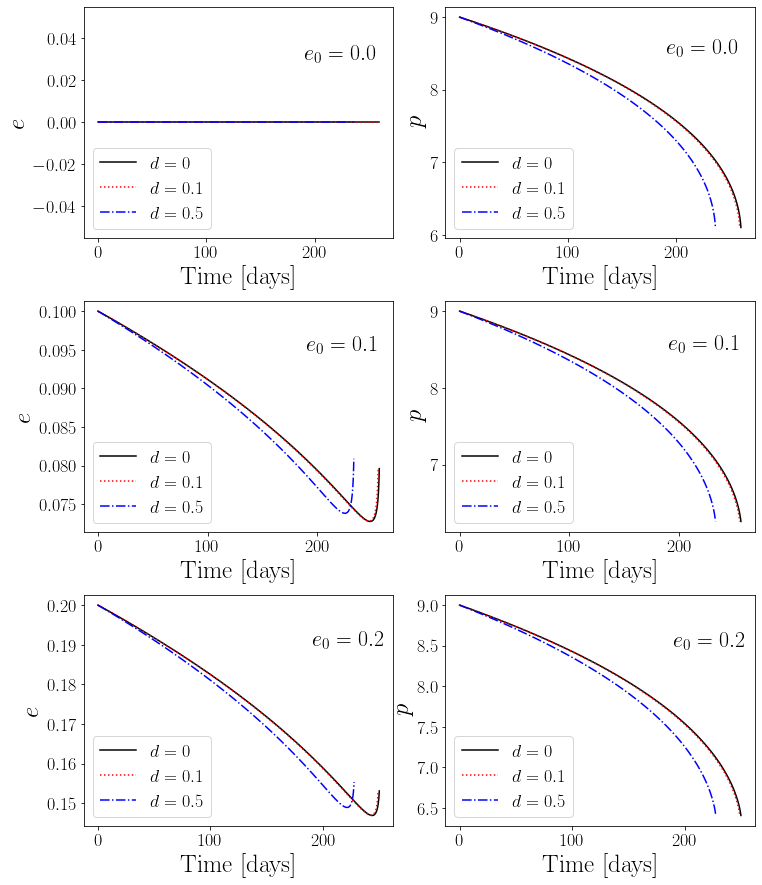

In [18]:
M = 1e6
a0 = 0.0  # will be ignored in Schwarzschild waveform
mu = 1e1
p=9.0
fsize=25
d0=0.0
d1=0.1
d2=0.5
fig=plt.figure(figsize=(3.6*3,6.2*2))
ticksize=18
T=1

e=0.0
grorbit1=traj(M, mu, 0.0, p, e, 1.0,d0,T=T)
dorbit11=traj(M, mu, 0.0, p, e, 1.0,d1,T=T)
dorbit1=traj(M, mu, 0.0, p, e, 1.0,d2,T=T)

ax=plt.subplot(321)
ax.plot(grorbit1[0]/3600/24,grorbit1[2],color='black',linestyle='-',label=r'$d=0$')
ax.plot(dorbit11[0]/3600/24,dorbit11[2],color='red',linestyle=':',label=r'$d={}$'.format(d1))
ax.plot(dorbit1[0]/3600/24,dorbit1[2],color='blue',linestyle='-.',label=r'$d={}$'.format(d2))
ax.set_xlabel(r'Time [days]',fontsize=fsize)
ax.set_ylabel(r'$e$',fontsize=fsize)
ax.tick_params(axis='both',labelsize=14)
ax.legend(loc='lower left',fontsize=18)
plt.tick_params(labelsize=ticksize)
plt.text(190,0.03,r'$e_0={}$'.format(e),fontsize=22)
# plt.title(r'$(p={},e={})$'.format(p,e),fontsize=22)

ax=plt.subplot(322)
ax.plot(grorbit1[0]/3600/24,grorbit1[1],color='black',linestyle='-',label=r'$d=0$')
ax.plot(dorbit11[0]/3600/24,dorbit11[1],color='red',linestyle=':',label=r'$d={}$'.format(d1))
ax.plot(dorbit1[0]/3600/24,dorbit1[1],color='blue',linestyle='-.',label=r'$d={}$'.format(d2))
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel(r'Time [days]',fontsize=fsize)
ax.set_ylabel(r'$p$',fontsize=fsize)
ax.legend(loc='lower left',fontsize=18)
plt.tick_params(labelsize=ticksize)
plt.text(190,8.5,r'$e_0={}$'.format(e),fontsize=22)


e=0.1
grorbit2=traj(M, mu, 0.0, p, e, 1.0,d0,T=T)
dorbit22=traj(M, mu, 0.0, p, e, 1.0,d1,T=T)
dorbit2=traj(M, mu, 0.0, p, e, 1.0,d2,T=T)

ax=plt.subplot(324)
ax.plot(grorbit2[0]/3600/24,grorbit2[1],color='black',linestyle='-',label=r'$d=0$')
ax.plot(dorbit22[0]/3600/24,dorbit22[1],color='red',linestyle=':',label=r'$d={}$'.format(d1))
ax.plot(dorbit2[0]/3600/24,dorbit2[1],color='blue',linestyle='-.',label=r'$d={}$'.format(d2))
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel(r'Time [days]',fontsize=fsize)
ax.set_ylabel(r'$p$',fontsize=fsize)
ax.legend(loc='lower left',fontsize=18)
plt.tick_params(labelsize=ticksize)
plt.text(190,8.5,r'$e_0={}$'.format(e),fontsize=22)

ax=plt.subplot(323)
ax.plot(grorbit2[0]/3600/24,grorbit2[2],color='black',linestyle='-',label=r'$d=0$')
ax.plot(dorbit22[0]/3600/24,dorbit22[2],color='red',linestyle=':',label=r'$d={}$'.format(d1))
ax.plot(dorbit2[0]/3600/24,dorbit2[2],color='blue',linestyle='-.',label=r'$d={}$'.format(d2))
ax.set_xlabel(r'Time [days]',fontsize=fsize)
ax.set_ylabel(r'$e$',fontsize=fsize)
ax.tick_params(axis='both',labelsize=14)
ax.legend(loc='lower left',fontsize=18)
plt.tick_params(labelsize=ticksize)
plt.text(190,0.095,r'$e_0={}$'.format(e),fontsize=22)


e=0.2
orbit1=traj(M, mu, 0.0, p, e, 1.0,d0,T=T)
orbit2=traj(M, mu, 0.0, p, e, 1.0,d1,T=T)
orbit3=traj(M, mu, 0.0, p, e, 1.0,d2,T=T)

ax=plt.subplot(326)
ax.plot(orbit1[0]/3600/24,orbit1[1],color='black',linestyle='-',label=r'$d=0$')
ax.plot(orbit2[0]/3600/24,orbit2[1],color='red',linestyle=':',label=r'$d={}$'.format(d1))
ax.plot(orbit3[0]/3600/24,orbit3[1],color='blue',linestyle='-.',label=r'$d={}$'.format(d2))
ax.tick_params(axis='both',labelsize=14)
ax.set_xlabel(r'Time [days]',fontsize=fsize)
ax.set_ylabel(r'$p$',fontsize=fsize)
ax.legend(loc='lower left',fontsize=18)
plt.tick_params(labelsize=ticksize)
plt.text(190,8.5,r'$e_0={}$'.format(e),fontsize=22)

ax=plt.subplot(325)
ax.plot(orbit1[0]/3600/24,orbit1[2],color='black',linestyle='-',label=r'$d=0$')
ax.plot(orbit2[0]/3600/24,orbit2[2],color='red',linestyle=':',label=r'$d={}$'.format(d1))
ax.plot(orbit3[0]/3600/24,orbit3[2],color='blue',linestyle='-.',label=r'$d={}$'.format(d2))
ax.set_xlabel(r'Time [days]',fontsize=fsize)
ax.set_ylabel(r'$e$',fontsize=fsize)
ax.tick_params(axis='both',labelsize=14)
ax.legend(loc='lower left',fontsize=18)
plt.tick_params(labelsize=ticksize)
plt.text(190,0.19,r'$e_0={}$'.format(e),fontsize=22)

plt.tight_layout()
plt.savefig('orbit.pdf')
plt.show()

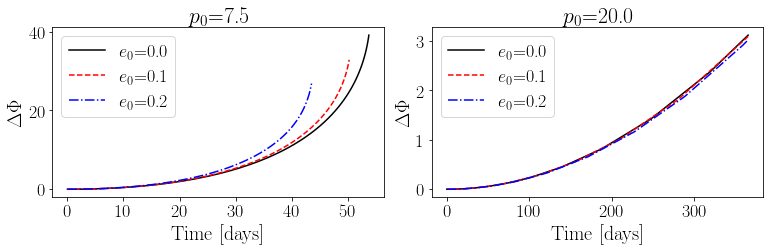

In [19]:
timelist=np.linspace(0,21*3600*24,10000)
T=1
M = 1e6
mu = 1e1
ticksize=18
linestyles=['-','--','-.']
colors=['black','red','blue']
fig=plt.figure(figsize=(5.4*2,3.6))
ax=plt.subplot(121)
for i,e in enumerate([0.0,0.1,0.2]):
    p=7.5
    grorbit33=traj(M, mu, 0.0, p, e, 1.0,d0,T=T)
    dorbit33=traj(M, mu, 0.0, p, e, 1.0,d1,T=T)
    
    grphi33=interpolate.interp1d(grorbit33[0],grorbit33[4],"cubic")
    dphi33=interpolate.interp1d(dorbit33[0],dorbit33[4],"cubic")
    timelist=dorbit33[0]
    grphilist33=grphi33(timelist)
    dphilist33=dphi33(timelist)
    ax.plot(timelist/3600/24,dphilist33-grphilist33,colors[i],linestyle=linestyles[i],label=r'$e_0$={e}'.format(e=e))
    ax.set_title(r'$p_0$={p}'.format(p=p),fontsize=22)
    ax.set_xlabel(r'Time [days]',fontsize=20)
    ax.set_ylabel(r'$\Delta\Phi$',fontsize=20)
    plt.tick_params(labelsize=ticksize)
    plt.legend(loc='upper left',fontsize=18)
    
ax=plt.subplot(122) 
for i,e in enumerate([0.0,0.1,0.2]):
    p=20.0
    grorbit33=traj(M, mu, 0.0, p, e, 1.0,d0,T=T)
    dorbit33=traj(M, mu, 0.0, p, e, 1.0,d1,T=T)
    grphi33=interpolate.interp1d(grorbit33[0],grorbit33[4],"cubic")
    dphi33=interpolate.interp1d(dorbit33[0],dorbit33[4],"cubic")
    timelist=dorbit33[0]
    grphilist33=grphi33(timelist)
    dphilist33=dphi33(timelist)
    ax.plot(timelist/3600/24,dphilist33-grphilist33,colors[i],linestyle=linestyles[i],label=r'$e_0$={e}'.format(e=e))
    ax.set_title(r'$p_0$={p}'.format(p=p),fontsize=22)
    ax.set_xlabel(r'Time [days]',fontsize=20)
    ax.set_ylabel(r'$\Delta\Phi$',fontsize=20)
    plt.tick_params(labelsize=ticksize)
    plt.legend(loc='upper left',fontsize=18)
plt.tight_layout()
plt.savefig('deltaphi1.pdf')
plt.show()

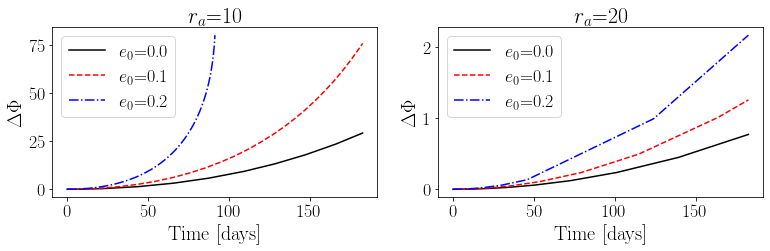

In [20]:
timelist=np.linspace(0,21*3600*24,10000)
T=0.5
M = 1e6
mu = 1e1
ticksize=18
linestyles=['-','--','-.']
colors=['black','red','blue']
fig=plt.figure(figsize=(5.4*2,3.6))
ax=plt.subplot(121)
for i,e in enumerate([0.0,0.1,0.2]):
    apa=10
    p=apa*(1-e)
    grorbit33=traj(M, mu, 0.0, p, e, 1.0,d0,T=T)
    dorbit33=traj(M, mu, 0.0, p, e, 1.0,d1,T=T)
    
    grphi33=interpolate.interp1d(grorbit33[0],grorbit33[4],"cubic")
    dphi33=interpolate.interp1d(dorbit33[0],dorbit33[4],"cubic")
    timelist=dorbit33[0]
    grphilist33=grphi33(timelist)
    dphilist33=dphi33(timelist)
    ax.plot(timelist/3600/24,dphilist33-grphilist33,colors[i],linestyle=linestyles[i],label=r'$e_0$={e}'.format(e=e))
    ax.set_title(r'$r_a$={p}'.format(p=apa),fontsize=22)
    ax.set_xlabel(r'Time [days]',fontsize=20)
    ax.set_ylabel(r'$\Delta\Phi$',fontsize=20)
    plt.tick_params(labelsize=ticksize)
    plt.legend(loc='upper left',fontsize=18)

    
ax=plt.subplot(122) 
for i,e in enumerate([0.0,0.1,0.2]):
    apa=20
    p=apa*(1-e)
    grorbit33=traj(M, mu, 0.0, p, e, 1.0,d0,T=T)
    dorbit33=traj(M, mu, 0.0, p, e, 1.0,d1,T=T)
    grphi33=interpolate.interp1d(grorbit33[0],grorbit33[4],"cubic")
    dphi33=interpolate.interp1d(dorbit33[0],dorbit33[4],"cubic")
    timelist=dorbit33[0]
    grphilist33=grphi33(timelist)
    dphilist33=dphi33(timelist)
    ax.plot(timelist/3600/24,dphilist33-grphilist33,colors[i],linestyle=linestyles[i],label=r'$e_0$={e}'.format(e=e))
    ax.set_title(r'$r_a$={p}'.format(p=apa),fontsize=22)
    ax.set_xlabel(r'Time [days]',fontsize=20)
    ax.set_ylabel(r'$\Delta\Phi$',fontsize=20)
    plt.tick_params(labelsize=ticksize)
    plt.legend(loc='upper left',fontsize=18)
plt.tight_layout()
plt.savefig('deltaphi2.pdf')
plt.show()

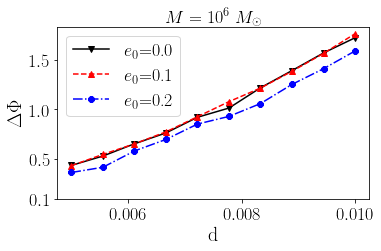

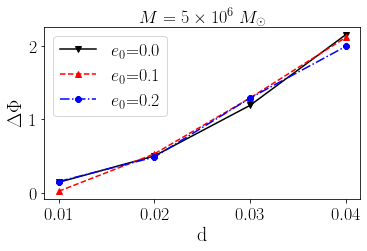

In [35]:

#Dephasing
labels=[None,r'$e_0=0.0$',r'$e_0=0.1$',r'$e_0=0.2$']
colors=[None,'black','red','blue','black','grey','pink']
markers=[None,'v','^','8','s','p','*']
linestyles=[None,'-','--','-.','.','-.','-.']
T=1
ticksize=18

dlist=np.linspace(0.005,0.01,10)
tollist=[]
M=1e6
for e0 in [0.0,0.1,0.2]:
    deltaphilist=[]
    for d1 in dlist:
        traj_args = [M, mu, 0.0, e0, 1.0,d1]
        traj_kwargs = {}
        index_of_p = 3
        t_out = 1.0
        p0 = get_p_at_t(
            traj,
            t_out,
            traj_args,
            index_of_p=3,
            index_of_a=2,
            index_of_e=4,
            index_of_x=5,
            traj_kwargs={},
            xtol=2e-12,
            rtol=8.881784197001252e-12,
            bounds=None,
        )
        dorbit33=traj(M, mu, 0.0, p0, e0, 1.0,d1)

        d0=0.0
        traj_args = [M, mu, 0.0, e0, 1.0,d0]
        p0 = get_p_at_t(
            traj,
            t_out,
            traj_args,
            index_of_p=3,
            index_of_a=2,
            index_of_e=4,
            index_of_x=5,
            traj_kwargs={},
            xtol=2e-12,
            rtol=8.881784197001252e-12,
            bounds=None,
        )
        grorbit33=traj(M, mu, 0.0, p0, e0, 1.0,d0,T=T)
        
        grphi33=interpolate.interp1d(grorbit33[0],grorbit33[4],"cubic")
        dphi33=interpolate.interp1d(dorbit33[0],dorbit33[4],"cubic")
        timelist=364*3600*24
        deltaphilist.append(grphi33(timelist)-dphi33(timelist))
        
    tollist.append(deltaphilist) 

Tfig=plt.figure(figsize=(5.4,3.6))
ax=plt.subplot(111)
elist=[0.0,0.1,0.2]
for i in [0,1,2]:
    ax.plot(dlist,tollist[i],ls=linestyles[i+1],label=r'$e_0$={}'.format(elist[i]),marker=markers[i+1],color=colors[i+1])
    ax.set_xlabel(r'd',fontsize=20)
    ax.set_ylabel(r'$\Delta\Phi$',fontsize=20)
    plt.tick_params(labelsize=ticksize)
    plt.legend(loc='upper left',fontsize=18)
    
plt.yticks([0.1,0.5,1.0,1.5])
plt.title(r'$M=10^{6}~M_{\odot}$',fontsize=18)
plt.tight_layout()
plt.savefig('dephasing.pdf')
plt.show()

dlist=[0.01,0.02,0.03,0.04]
tollist=[]
M=5e6
for e0 in [0.0,0.1,0.2]:
    deltaphilist=[]
    for d1 in dlist:
        traj_args = [M, mu, 0.0, e0, 1.0,d1]
        traj_kwargs = {}
        index_of_p = 3
        t_out = 1.0
        p0 = get_p_at_t(
            traj,
            t_out,
            traj_args,
            index_of_p=3,
            index_of_a=2,
            index_of_e=4,
            index_of_x=5,
            traj_kwargs={},
            xtol=2e-12,
            rtol=8.881784197001252e-12,
            bounds=None,
        )
        dorbit33=traj(M, mu, 0.0, p0, e0, 1.0,d1)

        d0=0.0
        traj_args = [M, mu, 0.0, e0, 1.0,d0]
        p0 = get_p_at_t(
            traj,
            t_out,
            traj_args,
            index_of_p=3,
            index_of_a=2,
            index_of_e=4,
            index_of_x=5,
            traj_kwargs={},
            xtol=2e-12,
            rtol=8.881784197001252e-12,
            bounds=None,
        )
        grorbit33=traj(M, mu, 0.0, p0, e0, 1.0,d0,T=T)
        
        grphi33=interpolate.interp1d(grorbit33[0],grorbit33[4],"cubic")
        dphi33=interpolate.interp1d(dorbit33[0],dorbit33[4],"cubic")
        timelist=364*3600*24
        deltaphilist.append(grphi33(timelist)-dphi33(timelist))
    tollist.append(deltaphilist) 
fig=plt.figure(figsize=(5.4,3.6))
ax=plt.subplot(111)
elist=[0.0,0.1,0.2]
for i in [0,1,2]:
    ax.plot(dlist,tollist[i],ls=linestyles[i+1],label=r'$e_0$={}'.format(elist[i]),marker=markers[i+1],color=colors[i+1])
    ax.set_xlabel(r'd',fontsize=20)
    ax.set_ylabel(r'$\Delta\Phi$',fontsize=20)
    plt.tick_params(labelsize=ticksize)
    plt.legend(loc='upper left',fontsize=18)
plt.title(r'$M=5\times 10^{6}~M_{\odot}$',fontsize=18)
plt.tight_layout()
plt.savefig('dephasing5e6.pdf')
plt.show()

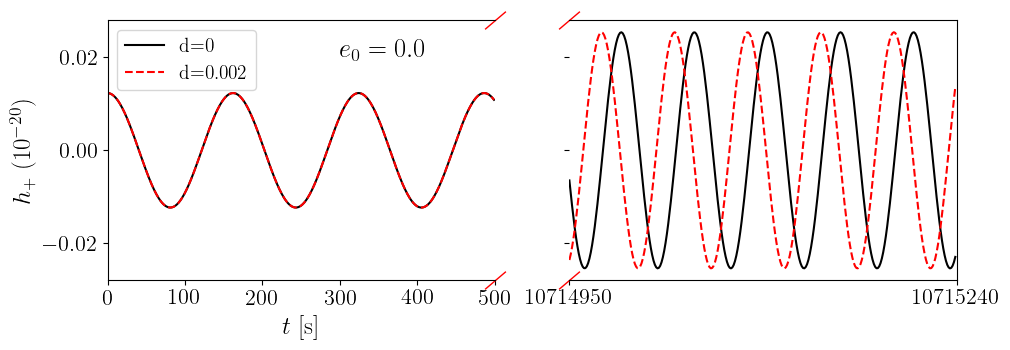

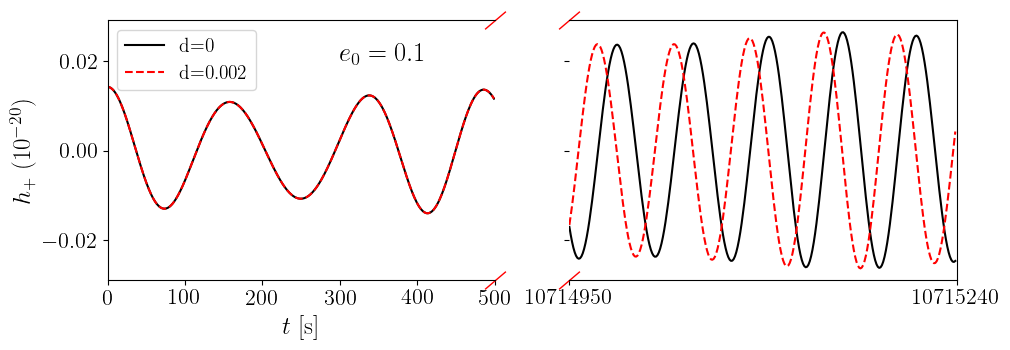

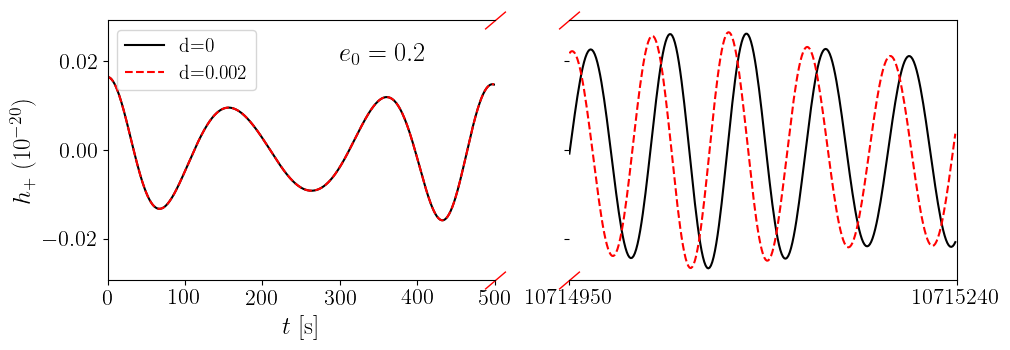

In [29]:
M=2*1e5
mu=1e1
d0=0.0
d1=0.002
T=1
dist = 1 # distance
qK = np.pi/3  # polar spin angle
phiK = np.pi/4  # azimuthal viewing angle
qS = np.pi/5  # polar sky angle
phiS = np.pi/6  # azimuthal viewing angle

numbermin=10724950-10000
numbermax=numbermin+50*5+40
dt = 1.0  # seconds
ticksize=25

for j,p in enumerate([14.0]):
    for i,e in enumerate([0.0,0.1,0.2]):
        
        AAK_out = wave_generator(M, mu, a0, p, e, Y0,dist, qS, phiS, qK, phiK,d0,
                          Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, dt=dt, T=T,mich=False)
        AAK_out2 = wave_generator(M, mu, a0, p, e, Y0,dist, qS, phiS, qK, phiK,d1,
                                  Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, dt=dt, T=T,mich=False)
        times=np.arange(len(AAK_out))
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, dpi=100,figsize=(10.2,3.6))
        num2=500
        ax1.plot(times[0:num2],AAK_out.real[0:num2]*10**20,'black',linestyle='-',label=r'd=0')
        ax1.plot(times[0:num2],AAK_out2.real[0:num2]*10**20,'red',linestyle='--',label=r'd={}'.format(d1))
        ax2.plot(times[numbermin:numbermax],AAK_out.real[numbermin:numbermax]*10**20,'black',linestyle='-',label=r'd=0')
        ax2.plot(times[numbermin:numbermax],AAK_out2.real[numbermin:numbermax]*10**20,'red',linestyle='--',label=r'd={}'.format(d1))
        ax2.set_xticks([numbermin,numbermax])
        ax2.set_xticklabels(['10714950','10715240'])
        ax1.text(300.0,0.02,r'$e_0={}$'.format(e),fontsize=19)

        ax1.set_xlim(0, num2)  #  子图1设置y轴范围，只显示部分图
        ax2.set_xlim(numbermin, numbermax)  # 子图2设置y轴范围，只显示部分图


        ax1.spines['right'].set_visible(False)#关闭子图1中底部脊
        ax2.spines['left'].set_visible(False)##关闭子图2中顶部脊
        d = .85  #设置倾斜度
        #绘制断裂处的标记
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=15,
                      linestyle='none', color='r', mec='r', mew=1, clip_on=False)
        ax1.plot([1, 1], [1, 0],transform=ax1.transAxes, **kwargs)
        ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)
        ax1.tick_params(labelsize=16)
        ax2.tick_params(labelsize=16)
        ax1.legend(loc='upper left',fontsize=14)
        ax1.set_xlabel(r'$t$ [s]',fontsize=18)
        ax1.set_ylabel(r'$h_{+}~(10^{-20})$',fontsize=18)
        plt.tight_layout()
        plt.savefig('waveforme{}.pdf'.format(e))
        plt.show()

In [23]:
#Faithfulness for e=0.0

# parameters
faithfulnesse02=[]
for d in [1e-3,2e-3,3e-3,4e-3,5e-3,6e-3,7e-3,8e-3,9e-3,1e-2,2e-2,3e-2,4e-2,5e-2]:
    T =1.0  # years
    dt = 10.0  # seconds
    M = 1e6
    a0 = 0.0  # will be ignored in Schwarzschild waveform
    mu = 1e1
    p0 = 9.46407266656996
    e0 = 0.0
    Y0 = 1.0  # will be ignored in Schwarzschild waveform

    qK = np.pi/4  # polar spin angle
    phiK = np.pi/4  # azimuthal viewing angle
    qS = np.pi/3 # polar sky angle
    phiS = np.pi/2  # azimuthal viewing angle
    dist = 0.1 # distance

    Phi_phi0 = 0.0
    Phi_theta0 = 0.0
    Phi_r0 = 0.0

    traj_argsgr = [M, mu, 0.0, e0, 1.0,0.0]
    traj_argsbd = [M, mu, 0.0, e0, 1.0,d]

    traj_kwargs = {}
    index_of_p = 3

    t_out = 1.0

    pgr= get_p_at_t(
        traj,
        t_out,
        traj_argsgr,
        index_of_p=3,
        index_of_a=2,
        index_of_e=4,
        index_of_x=5,
        traj_kwargs={},
        xtol=2e-12,
        rtol=8.881784197001252e-16,
        bounds=None,
    )
    pbd= get_p_at_t(
        traj,
        t_out,
        traj_argsbd,
        index_of_p=3,
        index_of_a=2,
        index_of_e=4,
        index_of_x=5,
        traj_kwargs={},
        xtol=2e-12,
        rtol=8.881784197001252e-16,
        bounds=None,
    )


    AAK_out = wave_generator(M, mu, a0, pgr, e0, Y0,dist, qS, phiS, qK, phiK,0.0,
                              Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, dt=dt, T=T,mich=True)

    AAK_out2 = wave_generator(M, mu, a0, pbd, e0, Y0,dist, qS, phiS, qK, phiK,d,
                              Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, dt=dt, T=T,mich=True)

    signalbdt=AAK_out2.real
    
    signalgrt=AAK_out.real
    
    c=299792458
    
    fstar=c/(2*np.pi*2.5e9)
    
    sampling_frequency=1/dt

    def sn(f):
        sa=(3*1e-15)**2
        sx=(1.5*1e-11)**2
        length=2.5e9
        sn11=sx/length**2+2*sa/(2*np.pi*f)**4/length**2*(1+(1e-4/f)**2)*(1+np.cos(2*np.pi*f*length/c)**2)
        return sn11/Rtransfunction(f)
    duration=dt*len(signalgrt)
    t0list=np.linspace(-4,4,200)
    overlaplist=[]
    signal_frequency_domain,freqs=bilby.utils.nfft(time_domain_strain=np.array(signalgrt),sampling_frequency=sampling_frequency)
    frequency_mask=(1e-5<freqs)&(freqs<1/(2*dt))
    power_spectral_density=sn(freqs[frequency_mask])
    signal_frequency_domain2=signal_frequency_domain[frequency_mask]
    snr_squared=bilby.gw.utils.optimal_snr_squared(signal=signal_frequency_domain2,power_spectral_density=power_spectral_density,duration=duration)
    signal_frequency_domainbd,freqsbd=bilby.utils.nfft(time_domain_strain=signalbdt,sampling_frequency=sampling_frequency)
    frequency_mask=(1e-5<freqsbd)&(freqsbd<1/(2*dt))
    power_spectral_density=sn(freqsbd[frequency_mask])
    signal_frequency_domain2bd=signal_frequency_domainbd[frequency_mask]
    snr_squaredbd=bilby.gw.utils.optimal_snr_squared(signal=signal_frequency_domain2bd,power_spectral_density=power_spectral_density,duration=duration)
    for t0 in t0list:   
        phaset0=np.exp(1j*2*np.pi*freqs[frequency_mask]*t0)
        overlap=bilby.gw.utils.noise_weighted_inner_product(signal_frequency_domain2*phaset0,signal_frequency_domain2bd,power_spectral_density,duration=duration)/np.sqrt(snr_squared*snr_squaredbd)
        overlaplist.append(overlap)
    print(np.max(np.array(np.abs(overlaplist))))
    faithfulnesse02.append(np.max(np.array(np.abs(overlaplist))))
np.savetxt('faithfulness{}.txt'.format(e0),faithfulnesse02)

0.9999926035153781
0.9998849143960576


KeyboardInterrupt: 

In [26]:
#Faithfulness for e=0.2

# parameters
faithfulnesse02=[]
for d in [1e-2,2e-2,3e-2,4e-2,5e-2,6e-2,7e-2]:
    T =1.0  # years
    dt = 10.0  # seconds
    M = 5*1e6
    a0 = 0.0  # will be ignored in Schwarzschild waveform
    mu = 1e1
    p0 = 9.46407266656996
    e0 = 0.2
    Y0 = 1.0  # will be ignored in Schwarzschild waveform

    qK = np.pi/4  # polar spin angle
    phiK = np.pi/4  # azimuthal viewing angle
    qS = np.pi/3 # polar sky angle
    phiS = np.pi/2  # azimuthal viewing angle
    dist = 0.1 # distance

    Phi_phi0 = 0.0
    Phi_theta0 = 0.0
    Phi_r0 = 0.0

    traj_argsgr = [M, mu, 0.0, e0, 1.0,0.0]
    traj_argsbd = [M, mu, 0.0, e0, 1.0,d]

    traj_kwargs = {}
    index_of_p = 3

    t_out = 1.0

    pgr= get_p_at_t(
        traj,
        t_out,
        traj_argsgr,
        index_of_p=3,
        index_of_a=2,
        index_of_e=4,
        index_of_x=5,
        traj_kwargs={},
        xtol=2e-12,
        rtol=8.881784197001252e-16,
        bounds=None,
    )
    pbd= get_p_at_t(
        traj,
        t_out,
        traj_argsbd,
        index_of_p=3,
        index_of_a=2,
        index_of_e=4,
        index_of_x=5,
        traj_kwargs={},
        xtol=2e-12,
        rtol=8.881784197001252e-16,
        bounds=None,
    )


    AAK_out = wave_generator(M, mu, a0, pgr, e0, Y0,dist, qS, phiS, qK, phiK,0.0,
                              Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, dt=dt, T=T,mich=True)

    AAK_out2 = wave_generator(M, mu, a0, pbd, e0, Y0,dist, qS, phiS, qK, phiK,d,
                              Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, dt=dt, T=T,mich=True)
    length=np.min([len(AAK_out),len(AAK_out2)])
    
    signalbdt=AAK_out2.real[:length]
    
    signalgrt=AAK_out.real[:length]
    
    c=299792458
    
    fstar=c/(2*np.pi*2.5e9)
    
    sampling_frequency=1/dt

    def sn(f):
        sa=(3*1e-15)**2
        sx=(1.5*1e-11)**2
        length=2.5e9
        sn11=sx/length**2+2*sa/(2*np.pi*f)**4/length**2*(1+(1e-4/f)**2)*(1+np.cos(2*np.pi*f*length/c)**2)
        return sn11/Rtransfunction(f)
    
    duration=dt*len(signalgrt)
    t0list=np.linspace(-4,4,200)
    overlaplist=[]
    signal_frequency_domain,freqs=bilby.utils.nfft(time_domain_strain=np.array(signalgrt),sampling_frequency=sampling_frequency)
    frequency_mask=(1e-5<freqs)&(freqs<1/(2*dt))
    power_spectral_density=sn(freqs[frequency_mask])
    signal_frequency_domain2=signal_frequency_domain[frequency_mask]
    snr_squared=bilby.gw.utils.optimal_snr_squared(signal=signal_frequency_domain2,power_spectral_density=power_spectral_density,duration=duration)
    signal_frequency_domainbd,freqsbd=bilby.utils.nfft(time_domain_strain=signalbdt,sampling_frequency=sampling_frequency)
    frequency_mask=(1e-5<freqsbd)&(freqsbd<1/(2*dt))
    power_spectral_density=sn(freqsbd[frequency_mask])
    signal_frequency_domain2bd=signal_frequency_domainbd[frequency_mask]
    snr_squaredbd=bilby.gw.utils.optimal_snr_squared(signal=signal_frequency_domain2bd,power_spectral_density=power_spectral_density,duration=duration)
    for t0 in t0list:   
        phaset0=np.exp(1j*2*np.pi*freqs[frequency_mask]*t0)
        overlap=bilby.gw.utils.noise_weighted_inner_product(signal_frequency_domain2*phaset0,signal_frequency_domain2bd,power_spectral_density,duration=duration)/np.sqrt(snr_squared*snr_squaredbd)
        overlaplist.append(overlap)
    print(np.max(np.array(np.abs(overlaplist))))
    faithfulnesse02.append(np.max(np.array(np.abs(overlaplist))))
np.savetxt('faithfulnessM5e6{}.txt'.format(e0),faithfulnesse02)

0.9970437658732423


KeyboardInterrupt: 

In [24]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
import scipy
origin = 'lower'
plt.rc('text', usetex=True)
plt.rc('font', family='calibri')
labels=[None,r'$e_0=0.0$',r'$e_0=0.1$',r'$e_0=0.2$']
colors=[None,'black','red','blue','black','grey','pink']
markers=[None,'v','^','8','s','p','*']
linestyles=[None,'-','--','-.','.','-.','-.']

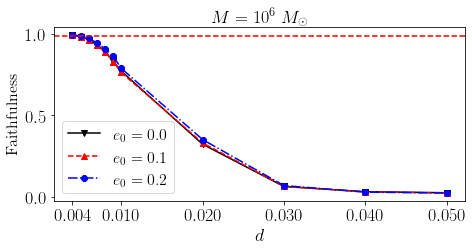

In [25]:
ds=[1e-3,2e-3,3e-3,4e-3,5e-3,6e-3,7e-3,8e-3,9e-3,1e-2,2e-2,3e-2,4e-2,5e-2]
e0=0.0
faithe00 =np.loadtxt('faithfulness{}.txt'.format(e0))
e0=0.1
faithe01=np.loadtxt('faithfulness{}.txt'.format(e0))
e0=0.2
faithe02=np.loadtxt('faithfulness{}.txt'.format(e0))
thread=0.988
plt.figure(figsize=(6.8,3.6))
num=3
i=1
plt.scatter(ds[num:],faithe00[num:],marker=markers[i],color=colors[i])
plt.plot(ds[num:],faithe00[num:],ls=linestyles[i],marker=markers[i],color=colors[i],label=labels[i])
i=2
plt.scatter(ds[num:],faithe01[num:],marker=markers[i],color=colors[i])
plt.plot(ds[num:],faithe01[num:],ls=linestyles[i],marker=markers[i],color=colors[i],label=labels[i])
i=3
plt.scatter(ds[num:],faithe02[num:],marker=markers[i],color=colors[i])
plt.plot(ds[num:],faithe02[num:],ls=linestyles[i],marker=markers[i],color=colors[i],label=labels[i])
plt.axhline(y=0.988, color='r', linestyle='--')
plt.tick_params(labelsize=18)
plt.xlabel(r'$d$',fontsize=18)
plt.ylabel(r'Faithfulness',fontsize=16)
plt.xticks([4e-3,1e-2,2e-2,3e-2,4e-2,5e-2])
plt.title(r'$M=10^{6}~M_{\odot}$',fontsize=18)
plt.legend(loc='lower left',fontsize=16)
plt.tight_layout()
plt.savefig('FaithfulnessMe6.pdf')
plt.show()

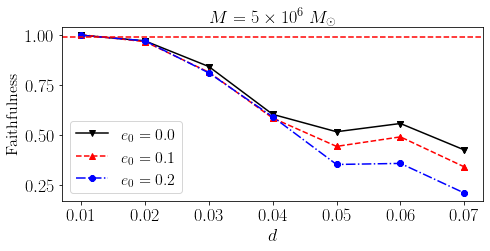

In [27]:
labels=[None,r'$e_0=0.0$',r'$e_0=0.1$',r'$e_0=0.2$']
colors=[None,'black','red','blue','black','grey','pink']
markers=[None,'v','^','8','s','p','*']
linestyles=[None,'-','--','-.','.','-.','-.']

plt.figure(figsize=(6.8,3.6))
ds=[1e-2,2e-2,3e-2,4e-2,5e-2,6e-2,7e-2]
e0=0.0
faithe00 =np.loadtxt('faithfulnessM5e6{}.txt'.format(e0))
e0=0.1
faithe01=np.loadtxt('faithfulnessM5e6{}.txt'.format(e0))
e0=0.2
faithe02=np.loadtxt('faithfulnessM5e6{}.txt'.format(e0))
thread=0.988
i=1
plt.scatter(ds,faithe00,marker=markers[i],color=colors[i])
plt.plot(ds,faithe00,ls=linestyles[i],marker=markers[i],color=colors[i],label=labels[i])
i=2
plt.scatter(ds,faithe01,marker=markers[i],color=colors[i])
plt.plot(ds,faithe01,ls=linestyles[i],marker=markers[i],color=colors[i],label=labels[i])
i=3
plt.scatter(ds,faithe02,marker=markers[i],color=colors[i])
plt.plot(ds,faithe02,ls=linestyles[i],marker=markers[i],color=colors[i],label=labels[i])

plt.axhline(y=0.988, color='r', linestyle='--')
plt.tick_params(labelsize=18)
plt.xlabel(r'$d$',fontsize=18)
plt.ylabel(r'Faithfulness',fontsize=16)
plt.xticks(ds)
# plt.xscale('log')
# plt.yscale('log')
plt.title(r'$M=5\times 10^{6}~M_{\odot}$',fontsize=18)
plt.legend(loc='lower left',fontsize=16)
plt.tight_layout()
plt.savefig('FaithfulnessM5e6.pdf')
plt.show()